<h2>Classification of Advertisements by Means of Supervised Learning Methods</h2>
<h3>Pavlo Mospan - 2020</h3>

### Importing all used libraries, downloading spacy model and preventing warnings from popping up

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 80

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import spacy
nlp = spacy.load('en_core_web_lg')

import re

import warnings
warnings.filterwarnings('ignore')

### Reading a ten 10 topic dataset

In [71]:
ads = pd.read_csv('amazon_nine_topic_labeled.csv', names=['ad', 'label'])
ads.describe()

,ad,label
count,8999,8999
unique,8931,10
top,USB Printer with 3 Year Printer Warranty,0
freq,6,1000


## labels correspond to the following topics
<li>0 - monitors</li>
<li>1 - printers</li>
<li>2 - headphones</li>
<li>3 - hair-care</li>
<li>4 - rings</li>
<li>5 - backpacks</li>
<li>6 - jeans</li>
<li>7 - sneakers</li>
<li>8 - watches</li>

In [72]:
# Removing NaN values
ads.dropna(inplace=True)

# Shuffling rows
ads = ads.sample(frac=1)
ads['ad'].describe()

count                                         8999
unique                                        8931
top       USB Printer with 3 Year Printer Warranty
freq                                             6
Name: ad, dtype: object

In [73]:
ads.head(10)

,ad,label
1988,Lexmark Printer Caster Base (40G0855),1
4393,"Charles Winston, S Silver, Cubic Zirconia Trinity Ring, with Charles Winston...",4
5800,"Vera Bradley Essential Compact Backpack (Navy), Small",5
6489,DL1961 Womens Florence Instasculpt in Riker,6
2323,LG Electronics Tone Ultra (HBS-800) Bluetooth Stereo Headset - Black (Renewed),2
4464,Wide Statement Ring in Sterling Silver Genuine Turquoise & Gemstones (SELECT...,4
4059,Gem Stone King 4.12 Ct Oval Blue Created Sapphire 925 Yellow Gold Plated Sil...,4
1336,Epson WorkForce ET-3750 EcoTank Wireless Color All-in-One Supertank Printer ...,1
8688,SEKONDA Unisex-Adult Analogue Classic Quartz Watch with Stainless Steel Stra...,8
3345,Baistom Quiet Kids Hair Trimmer Pro - Baby Hair Clipper - Rechargeable Water...,3


### Top words in dataset before feature engineering

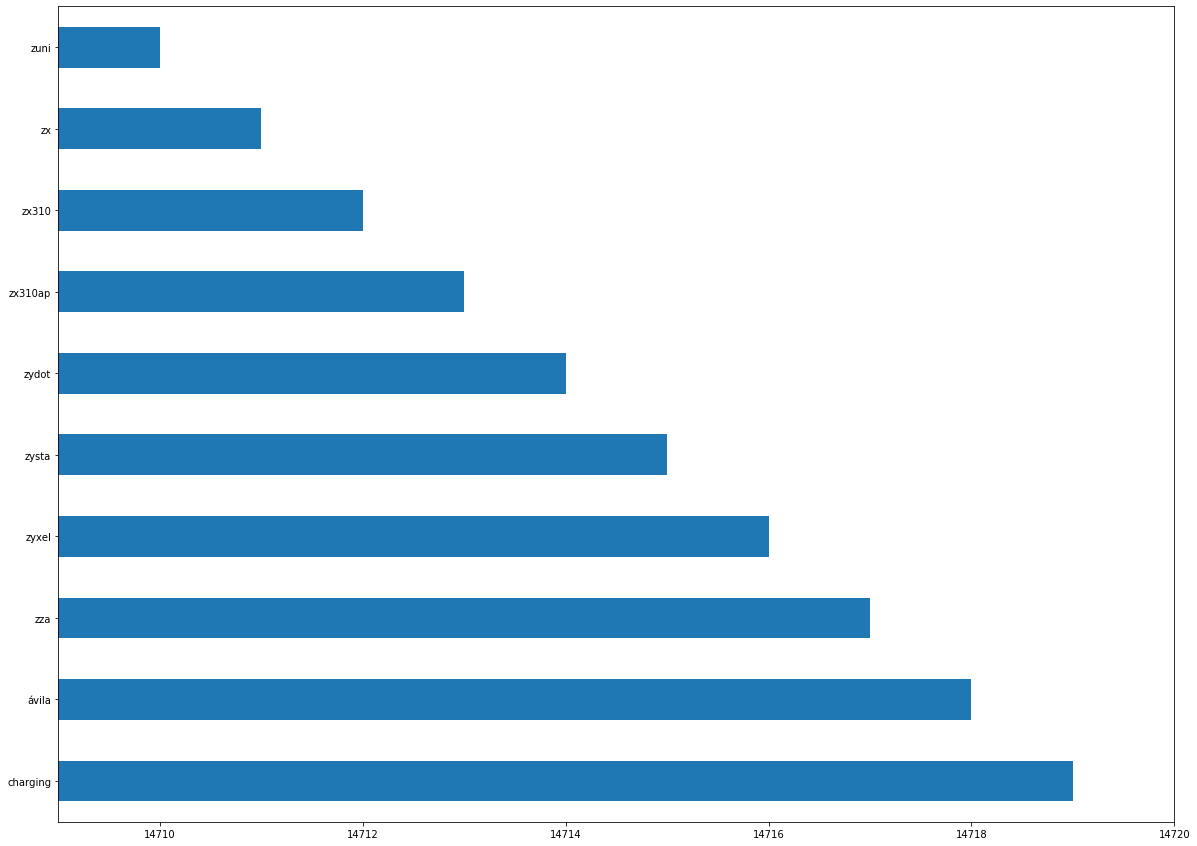

In [74]:
# count vetorizing object
count_vectorizer = CountVectorizer()

# fitting CV
count_vectorizer.fit(ads['ad'])

# collecting the vocabulary items used in vectorizer
dictionary = count_vectorizer.vocabulary_.items()

# Storing vocab and counts in a pandas DF
vocab = []
count = []

# iterating through each vocab and count append the value to designated list
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
    
# storing the count in pandas DF with vocab as index
vocab_bef_stem = pd.Series(count, index = vocab)

# sorting the DF
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

top_vocab = vocab_bef_stem.head(10)
top_vocab.plot(kind = 'barh', figsize=(20, 15), xlim=(14709, 14720))

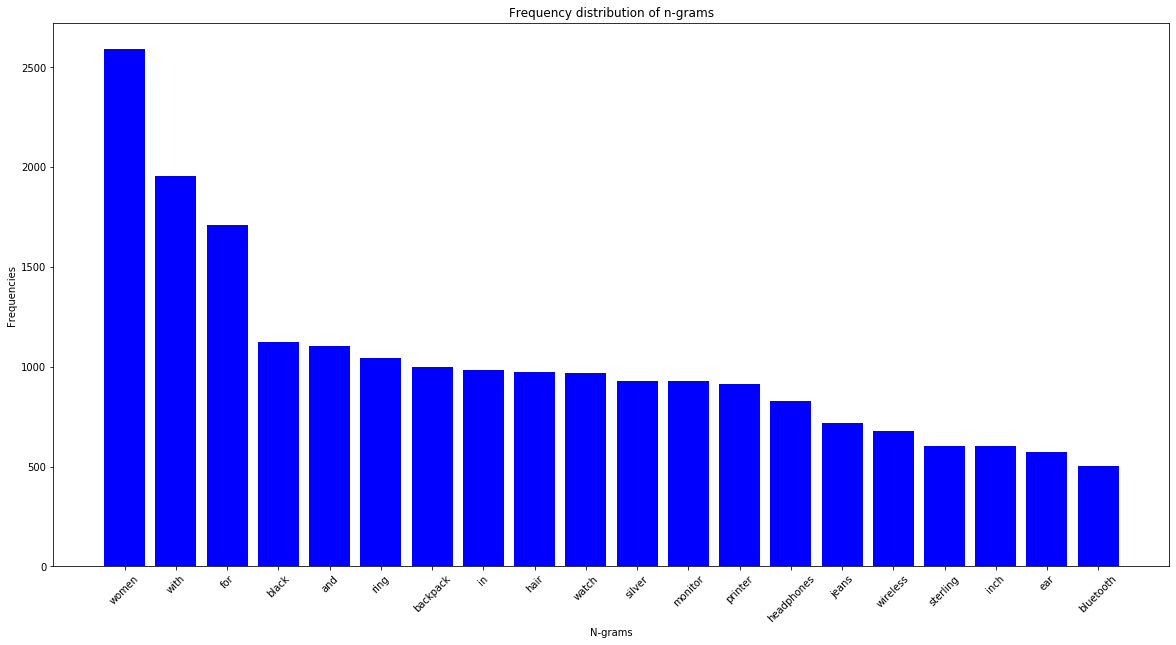

In [75]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 1),
                                          num_ngrams=20):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(20,10))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()
    
    
plot_frequency_distribution_of_ngrams(ads['ad'])

### Visualizing the length of the documents

In [76]:
def length(text):
    """Function that returns the length of a text"""
    return len(text)

In [77]:
ads['length'] = ads['ad'].apply(length)
ads.describe()

,length
count,8999.000000
mean,83.477831
std,44.061432
min,1.000000
25%,51.000000
50%,72.000000
75%,104.000000
max,305.000000


In [78]:
ads.head()

,ad,label,length
1988,Lexmark Printer Caster Base (40G0855),1,37
4393,"Charles Winston, S Silver, Cubic Zirconia Trinity Ring, with Charles Winston...",4,138
5800,"Vera Bradley Essential Compact Backpack (Navy), Small",5,53
6489,DL1961 Womens Florence Instasculpt in Riker,6,43
2323,LG Electronics Tone Ultra (HBS-800) Bluetooth Stereo Headset - Black (Renewed),2,78


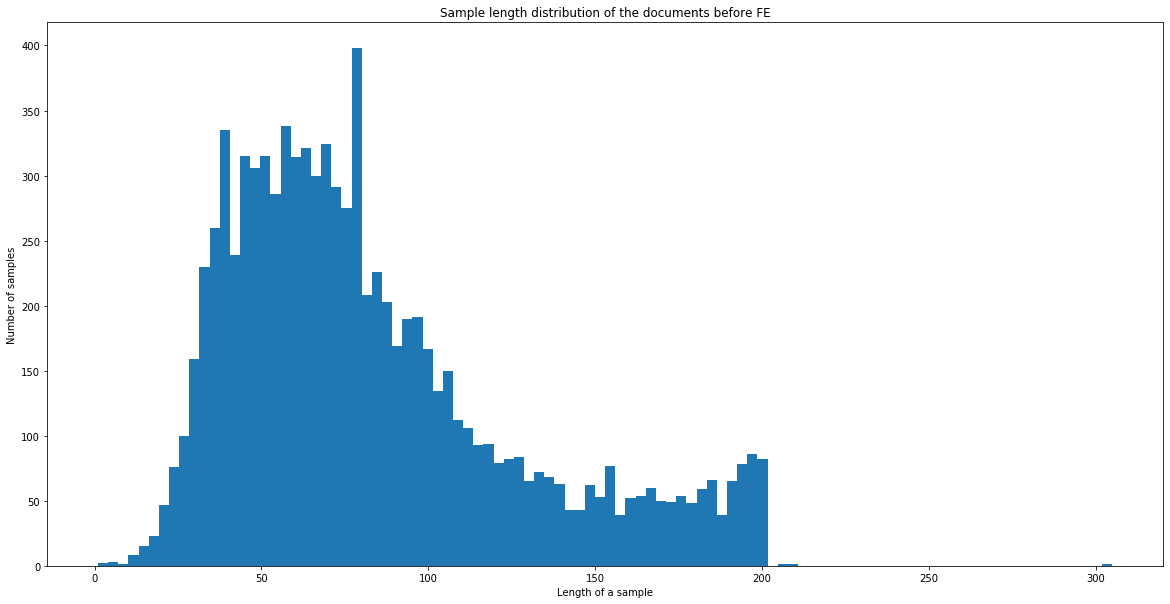

In [79]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    
    plt.figure(figsize=(20,10))
    plt.hist([len(s) for s in sample_texts], 100)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution of the documents before FE')
    plt.show()
    

plot_sample_length_distribution(ads['ad'])

### Removing stopwords

In [80]:
def stopwords(text):
    """
    Function for removing 
        - stopwords,
        - punctuation,
        - numbers / digits
        - words containing numbers
    """
    doc = nlp(text)
    for token in doc:
        text = [token.text for token in doc if 
                not token.is_stop 
                and not token.is_punct 
                and not token.is_digit]
        
        
    # joining the list of words with space separator
    joined_text = " ".join(text)
    # removing words that contain any sort of numbers, like 'G2420-BK' or 'G1W40A#BGJ '
    re_text = re.sub(r"\S*\d\S*", '', joined_text).strip()
    
    return re_text

In [81]:
ads['SW'] = ads['ad'].apply(stopwords)
ads.head()

,ad,label,length,SW
1988,Lexmark Printer Caster Base (40G0855),1,37,Lexmark Printer Caster Base
4393,"Charles Winston, S Silver, Cubic Zirconia Trinity Ring, with Charles Winston...",4,138,Charles Winston S Silver Cubic Zirconia Trinity Ring Charles Winston Scintil...
5800,"Vera Bradley Essential Compact Backpack (Navy), Small",5,53,Vera Bradley Essential Compact Backpack Navy Small
6489,DL1961 Womens Florence Instasculpt in Riker,6,43,Womens Florence Instasculpt Riker
2323,LG Electronics Tone Ultra (HBS-800) Bluetooth Stereo Headset - Black (Renewed),2,78,LG Electronics Tone Ultra Bluetooth Stereo Headset Black Renewed


In [82]:
ads['ad']

1988                                              Lexmark Printer Caster Base (40G0855)
4393    Charles Winston, S Silver, Cubic Zirconia Trinity Ring, with Charles Winston...
5800                              Vera Bradley Essential Compact Backpack (Navy), Small
6489                                        DL1961 Womens Florence Instasculpt in Riker
2323     LG Electronics Tone Ultra (HBS-800) Bluetooth Stereo Headset - Black (Renewed)
                                             ...                                       
3726                 Cover Your Gray Fill-in Powder Two Shades in One, Dark Brown/Black
3328    Moroccan Argan Oil Shampoo Sulfate Free for Normal Oily Curly Dry Damaged Co...
299                                   HP-CTO E4U30AA#ABA 18.9" EliteDisplay E190i LEDMN
3116    11" Inch Styrofoam Mannequin Wig Head Foam Manikin Display Head Wig Hat Stan...
5491      Kids Backpacks for Little Girls by Fenrici, 16 Inch Book Bags for Preschooler
Name: ad, Length: 8999, dtype: o

In [83]:
ads['SW']

1988                                                        Lexmark Printer Caster Base
4393    Charles Winston S Silver Cubic Zirconia Trinity Ring Charles Winston Scintil...
5800                                 Vera Bradley Essential Compact Backpack Navy Small
6489                                                  Womens Florence Instasculpt Riker
2323                  LG Electronics Tone Ultra  Bluetooth Stereo Headset Black Renewed
                                             ...                                       
3726                                     Cover Gray Fill Powder Shades Dark Brown Black
3328    Moroccan Argan Oil Shampoo Sulfate Free Normal Oily Curly Dry Damaged Color ...
299                                                        HP CTO   EliteDisplay  LEDMN
3116    Inch Styrofoam Mannequin Wig Head Foam Manikin Display Head Wig Hat Stand Wh...
5491                     Kids Backpacks Little Girls Fenrici Inch Book Bags Preschooler
Name: SW, Length: 8999, dtype: o

### 1. Getting rid off of two whitespaces
### 2. Replacing rows with no entries with NaN to dropna them

In [84]:
# 1
ads['SW']=ads['SW'].str.replace("  "," ")

# 2
ads['SW'].replace('', np.nan, inplace=True)
ads.dropna(inplace=True)
ads['SW'].describe()

count                   8998
unique                  8582
top       HP Deskjet Printer
freq                      11
Name: SW, dtype: object

### Top words in dataset after FE

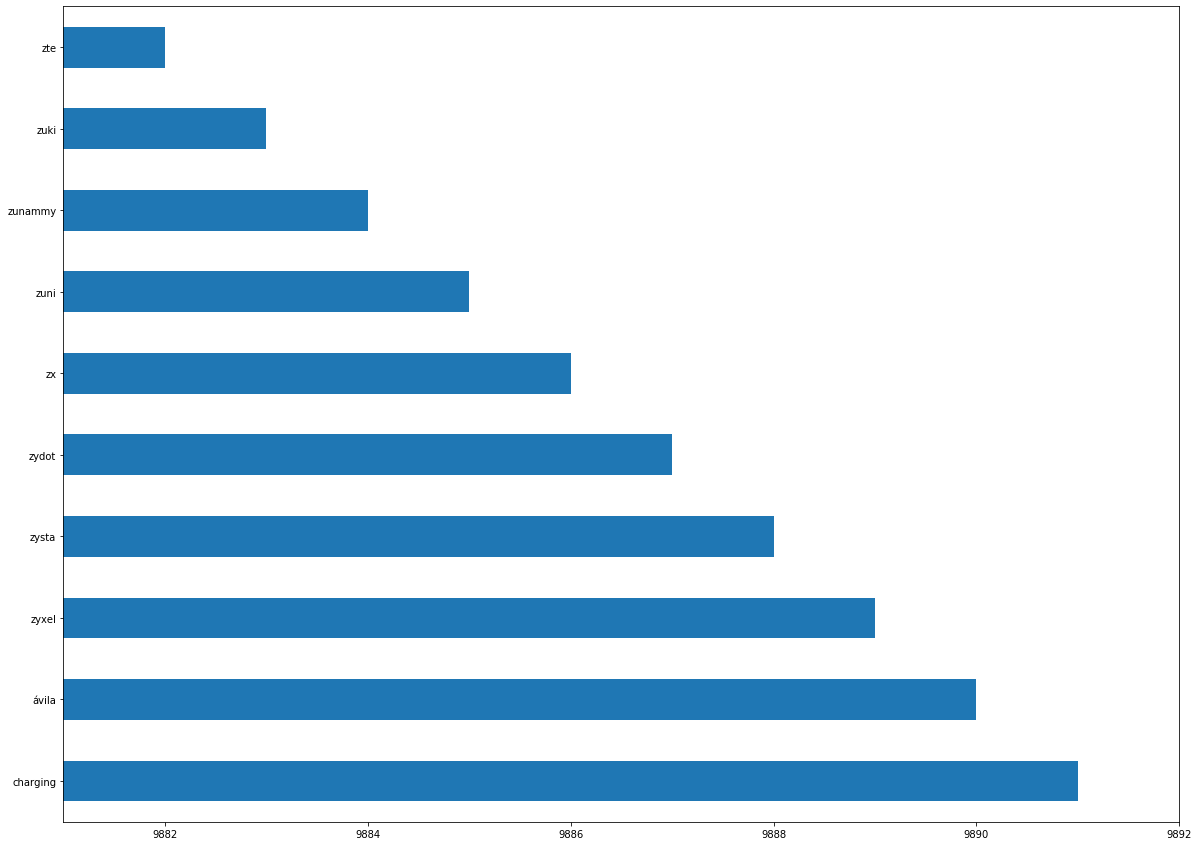

In [85]:
# count vetorizing object
count_vectorizer = CountVectorizer()

# fitting CV
count_vectorizer.fit(ads['SW'])

# collecting the vocabulary items used in vectorizer
dictionary = count_vectorizer.vocabulary_.items()

# Storing vocab and counts in a pandas DF
vocab = []
count = []

# iterating through each vocab and count append the value to designated list
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
    
# storing the count in pandas DF with vocab as index
vocab_bef_stem = pd.Series(count, index = vocab)

# sorting the DF
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

top_vocab = vocab_bef_stem.head(10)
top_vocab.plot(kind = 'barh', figsize=(20, 15), xlim=(9881, 9892))

### FE in action

In [86]:
print(ads['ad'][8096], ' ====', ads['SW'][8096])

Moog Paris Bohême Women's Watch with Gray Dial, Silver Strap in Stainless Steel - M46144-003  ==== Moog Paris Bohême Women Watch Gray Dial Silver Strap Stainless Steel


#### I had some troubleshooting with this string when making accuracy validation

In [101]:
i = ads[ ads['label'] == ' Letsfit Wireless Headphones'].index
ads.drop(i, inplace = True)

ads.loc[ads['label'] == ' Letsfit Wireless Headphones']

,ad,label,length,SW,Topic Label,Topic Name,Predicted Label


# NMF

In [87]:
ads.head()

,ad,label,length,SW
1988,Lexmark Printer Caster Base (40G0855),1,37,Lexmark Printer Caster Base
4393,"Charles Winston, S Silver, Cubic Zirconia Trinity Ring, with Charles Winston...",4,138,Charles Winston S Silver Cubic Zirconia Trinity Ring Charles Winston Scintil...
5800,"Vera Bradley Essential Compact Backpack (Navy), Small",5,53,Vera Bradley Essential Compact Backpack Navy Small
6489,DL1961 Womens Florence Instasculpt in Riker,6,43,Womens Florence Instasculpt Riker
2323,LG Electronics Tone Ultra (HBS-800) Bluetooth Stereo Headset - Black (Renewed),2,78,LG Electronics Tone Ultra Bluetooth Stereo Headset Black Renewed


In [88]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2)

dtm = tfidf.fit_transform(ads['SW'])

dtm

<8998x4728 sparse matrix of type '<class 'numpy.float64'>'
	with 83634 stored elements in Compressed Sparse Row format>

In [89]:
dtm.shape

(8998, 4728)

In [90]:
nmf_model = NMF(n_components=9,random_state=42)

# This can take awhile, we're dealing with a large amount of documents!
nmf_model.fit(dtm)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=9, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [91]:
len(tfidf.get_feature_names())

4728

In [92]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 5 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-5:]])
    print('\n')

THE TOP 5 WORDS FOR TOPIC #0
['stainless', 'steel', 'strap', 'quartz', 'watch']


THE TOP 5 WORDS FOR TOPIC #1
['earbuds', 'wireless', 'ear', 'bluetooth', 'headphones']


THE TOP 5 WORDS FOR TOPIC #2
['hdmi', 'screen', 'lcd', 'led', 'monitor']


THE TOP 5 WORDS FOR TOPIC #3
['white', 'gold', 'sterling', 'silver', 'ring']


THE TOP 5 WORDS FOR TOPIC #4
['canon', 'color', 'photo', 'hp', 'printer']


THE TOP 5 WORDS FOR TOPIC #5
['denim', 'rise', 'women', 'skinny', 'jeans']


THE TOP 5 WORDS FOR TOPIC #6
['travel', 'school', 'laptop', 'bag', 'backpack']


THE TOP 5 WORDS FOR TOPIC #7
['sneakers', 'low', 'fashion', 'sneaker', 'women']


THE TOP 5 WORDS FOR TOPIC #8
['brush', 'accessories', 'clips', 'oz', 'hair']




In [93]:
topic_results = nmf_model.transform(dtm)

In [94]:
ads['Topic Label'] = topic_results.argmax(axis=1)

my_topic_dictionary = {0: 'Watches', 
                       1: 'Headphones', 
                       2: 'Monitors', 
                       3: 'Ring', 
                       4: 'Printer', 
                       5: 'Jeans', 
                       6: 'Backpack',
                       7: 'Sneakers', 
                       8: 'Hair-Care'}

ads['Topic Name'] = ads['Topic Label'].map(my_topic_dictionary)
ads

,ad,label,length,SW,Topic Label,Topic Name
1988,Lexmark Printer Caster Base (40G0855),1,37,Lexmark Printer Caster Base,4,Printer
4393,"Charles Winston, S Silver, Cubic Zirconia Trinity Ring, with Charles Winston...",4,138,Charles Winston S Silver Cubic Zirconia Trinity Ring Charles Winston Scintil...,3,Ring
5800,"Vera Bradley Essential Compact Backpack (Navy), Small",5,53,Vera Bradley Essential Compact Backpack Navy Small,6,Backpack
6489,DL1961 Womens Florence Instasculpt in Riker,6,43,Womens Florence Instasculpt Riker,5,Jeans
2323,LG Electronics Tone Ultra (HBS-800) Bluetooth Stereo Headset - Black (Renewed),2,78,LG Electronics Tone Ultra Bluetooth Stereo Headset Black Renewed,1,Headphones
...,...,...,...,...,...,...
3726,"Cover Your Gray Fill-in Powder Two Shades in One, Dark Brown/Black",3,66,Cover Gray Fill Powder Shades Dark Brown Black,8,Hair-Care
3328,Moroccan Argan Oil Shampoo Sulfate Free for Normal Oily Curly Dry Damaged Co...,3,122,Moroccan Argan Oil Shampoo Sulfate Free Normal Oily Curly Dry Damaged Color ...,8,Hair-Care
299,"HP-CTO E4U30AA#ABA 18.9"" EliteDisplay E190i LEDMN",0,49,HP CTO EliteDisplay LEDMN,4,Printer
3116,"11"" Inch Styrofoam Mannequin Wig Head Foam Manikin Display Head Wig Hat Stan...",3,146,Inch Styrofoam Mannequin Wig Head Foam Manikin Display Head Wig Hat Stand Wh...,8,Hair-Care


<li>0 - monitors</li>
<li>1 - printers</li>
<li>2 - headphones</li>
<li>3 - hair-care</li>
<li>4 - rings</li>
<li>5 - backpacks</li>
<li>6 - jeans</li>
<li>7 - shoes</li>
<li>8 - watches</li>


                      {0: 'Watches', 
                       1: 'Headphones', 
                       2: 'Monitors', 
                       3: 'Ring', 
                       4: 'Printer', 
                       5: 'Jeans', 
                       6: 'Backpack',
                       7: 'Sneakers', 
                       8: 'Hair-Care'}

In [95]:
def reassign_2_label(topic):
    switcher = {
        0: 8,
        1: 2,
        2: 0,
        3: 4,
        4: 1,
        5: 6,
        6: 5,
        7: 7,
        8: 3
    }
    return switcher.get(topic)

In [96]:
ads['Predicted Label'] = ads['Topic Label'].apply(reassign_2_label)
ads.head()

,ad,label,length,SW,Topic Label,Topic Name,Predicted Label
1988,Lexmark Printer Caster Base (40G0855),1,37,Lexmark Printer Caster Base,4,Printer,1
4393,"Charles Winston, S Silver, Cubic Zirconia Trinity Ring, with Charles Winston...",4,138,Charles Winston S Silver Cubic Zirconia Trinity Ring Charles Winston Scintil...,3,Ring,4
5800,"Vera Bradley Essential Compact Backpack (Navy), Small",5,53,Vera Bradley Essential Compact Backpack Navy Small,6,Backpack,5
6489,DL1961 Womens Florence Instasculpt in Riker,6,43,Womens Florence Instasculpt Riker,5,Jeans,6
2323,LG Electronics Tone Ultra (HBS-800) Bluetooth Stereo Headset - Black (Renewed),2,78,LG Electronics Tone Ultra Bluetooth Stereo Headset Black Renewed,1,Headphones,2


In [97]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [98]:
confusion_matrix = pd.crosstab(ads['label'], ads['Predicted Label'])

In [99]:
confusion_matrix

Predicted Label,0,1,2,3,4,5,6,7,8
label,,,,,,,,,
0,976,11,2,3,1,5,0,0,2
1,23,949,8,6,3,4,1,3,2
2,10,3,966,1,6,7,2,2,1
3,1,3,2,964,8,4,5,10,3
4,0,0,0,1,985,0,1,9,4
5,1,1,3,25,7,944,7,10,2
6,0,0,0,0,0,0,945,53,2
7,1,0,2,0,7,16,25,946,3
8,1,0,4,2,34,4,16,64,875


In [102]:
ads.describe()

,length,Topic Label,Predicted Label
count,8997.000000,8997.000000,8997.000000
mean,83.488274,4.072802,3.991775
std,44.057581,2.562802,2.561589
min,2.000000,0.000000,0.000000
25%,51.000000,2.000000,2.000000
50%,72.000000,4.000000,4.000000
75%,104.000000,6.000000,6.000000
max,305.000000,8.000000,8.000000


In [103]:
confusion_matrix = pd.crosstab(ads['label'], ads['Predicted Label'])
confusion_matrix

Predicted Label,0,1,2,3,4,5,6,7,8
label,,,,,,,,,
0,976,11,2,3,1,5,0,0,2
1,23,949,8,6,3,4,1,3,2
2,10,3,966,1,6,7,2,2,1
3,1,3,2,964,8,4,5,10,3
4,0,0,0,1,985,0,1,9,4
5,1,1,3,25,7,944,7,10,2
6,0,0,0,0,0,0,945,53,2
7,1,0,2,0,7,16,25,946,3
8,1,0,4,2,34,4,16,64,875


In [105]:
ads['label'].describe()

count     8997
unique       9
top          0
freq      1000
Name: label, dtype: object

In [106]:
ads['Predicted Label'].describe()

count    8997.000000
mean        3.991775
std         2.561589
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max         8.000000
Name: Predicted Label, dtype: float64

In [108]:
ads.dtypes

ad                 object
label              object
length              int64
SW                 object
Topic Label         int64
Topic Name         object
Predicted Label     int64
dtype: object

### ads['label'] is an object, which in pandas language means string
#### to provide accuracy validation we got to make it INT

In [111]:
label = pd.DataFrame(ads['label'].astype(str).astype(int))

In [113]:
label.head()

,label
1988,1
4393,4
5800,5
6489,6
2323,2


In [114]:
accuracy_score(label['label'], ads['Predicted Label'])

0.9503167722574192

In [117]:
print(classification_report(label['label'], ads['Predicted Label']))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       0.98      0.95      0.97       999
           2       0.98      0.97      0.97       998
           3       0.96      0.96      0.96      1000
           4       0.94      0.98      0.96      1000
           5       0.96      0.94      0.95      1000
           6       0.94      0.94      0.94      1000
           7       0.86      0.95      0.90      1000
           8       0.98      0.88      0.92      1000

    accuracy                           0.95      8997
   macro avg       0.95      0.95      0.95      8997
weighted avg       0.95      0.95      0.95      8997



# Nearest Neighbors Search

In [118]:
knn = NearestNeighbors(n_neighbors=9, metric='cosine')
knn.fit(dtm)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                 radius=1.0)

In [119]:
knn.kneighbors(dtm[0:1], return_distance=False)

array([[   0, 6892, 6337, 5702, 3586, 4441, 2714, 7349, 1280]])

In [120]:
knn.kneighbors(dtm[0:1], return_distance=True)

(array([[0.        , 0.34985285, 0.34985285, 0.34985285, 0.34985285,
         0.45031152, 0.45031152, 0.45031152, 0.45031152]]),
 array([[   0, 6892, 6337, 5702, 3586, 4441, 2714, 7349, 1280]]))

In [136]:
input_ad = ['New and Grade A LCD Panel SP24V001 with 90 Days Warranty',
            'Kodak 3D Printer Portrait',
            'Beats by Dr. Dre - Beats Solo3 Wireless On-Ear Headphones - Beats Pop Collection- POP Indigo(Renewed)',
            'Revlon One-Step Hair Dryer & Styler, Black',
            "Leo's Creations Libra Zodiac Ring",
            "Puma 19.5"" The Pace Backpack - Camouflage/Orange with Laptop Sleeve Back Pack",
            "Lucky Brand Girls' Fashion Denim Jean",
            "Frozen Sneakers Shoes for Girls with Elsa and Anna",
            "Dakota Leather Casual Women's Watch"]
input_features = tfidf.transform(input_ad)

In [137]:
D, N = knn.kneighbors(input_features, n_neighbors=2, return_distance=True)

for input_text, distances, neighbors in zip(input_ad, D, N):
    print("INPUT TEXT = ", input_text[:200], "\n\n")
    for dist, neighbor_idx in zip(distances, neighbors):
        print("Distance = ", dist, "Neighbor idx = ", neighbor_idx)
        print('TOPIC : ', ads['Topic Name'][neighbor_idx])
        print("-"*100)
    print("="*100)
    print()

INPUT TEXT =  New and Grade A LCD Panel SP24V001 with 90 Days Warranty 


Distance =  0.16051742632335853 Neighbor idx =  1015
TOPIC :  Printer
----------------------------------------------------------------------------------------------------
Distance =  0.16051742632335853 Neighbor idx =  1061
TOPIC :  Printer
----------------------------------------------------------------------------------------------------

INPUT TEXT =  Kodak 3D Printer Portrait 


Distance =  0.0 Neighbor idx =  1397
TOPIC :  Printer
----------------------------------------------------------------------------------------------------
Distance =  0.5508541966796804 Neighbor idx =  6450
TOPIC :  Jeans
----------------------------------------------------------------------------------------------------

INPUT TEXT =  Beats by Dr. Dre - Beats Solo3 Wireless On-Ear Headphones - Beats Pop Collection- POP Indigo(Renewed) 


Distance =  0.31741390133499436 Neighbor idx =  2952
TOPIC :  Headphones
------------------------

In [132]:
ads.loc[ads['ad'] == "Lucky Brand Girls' Fashion Denim Jean"]

,ad,label,length,SW,Topic Label,Topic Name,Predicted Label


# Random Forest

In [34]:
from sklearn import pipeline, ensemble, preprocessing, feature_extraction, metrics

In [35]:
clf = pipeline.Pipeline([
    ('tfidf_vectorizer', feature_extraction.text.TfidfVectorizer(lowercase=True)),
    ('rf_classifier', ensemble.RandomForestClassifier(n_estimators=500, verbose=1, n_jobs=1))
])

In [36]:
X_train, X_test, y_train, y_test = train_test_split(ads['SW'], ads['NMF Topic'], test_size=0.3)

In [37]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    9.7s finished


Pipeline(memory=None,
         steps=[('tfidf_vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 toke...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                               

In [93]:
y_pred = clf.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


In [94]:
metrics.confusion_matrix(y_test, y_pred)

array([[270,   1,   0,   0,   0,   0,   1,  11,   0,   1],
       [  0, 277,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 301,   0,   0,   0,   1,   4,   0,   0],
       [  0,   1,   0, 277,   0,   1,   2,   4,   0,   1],
       [  0,   1,   2,   0, 220,   0,   0,   2,   0,   0],
       [  0,   0,   0,   1,   0, 290,   0,   7,   0,   1],
       [  4,   0,   0,   8,   0,   0, 307,   4,   0,   1],
       [  0,   0,   1,   0,   0,   2,   1, 545,   0,   5],
       [  1,   0,   2,   0,   2,   1,   0,   0,  69,   1],
       [  5,   1,   1,   2,   0,   2,   2,  23,   0, 313]])

In [95]:
metrics.accuracy_score(y_test, y_pred)

0.9627516778523489

In [96]:
ads

,ad,len,SW,NMF Topic,NMF Topic Label
0,Lenovo ThinkVision L1900p 19-inch Flat Panel L...,79,Lenovo ThinkVision Flat Panel LCD Monitor Ene...,2,Monitor
1,Mellewell 14-Inch Single Towel Bar Towel Holde...,108,Mellewell Single Towel Bar Towel Holder Bathro...,7,Bath
2,Kodak 3D Printer Portrait,25,Kodak Printer Portrait,4,Scanner
3,Fox Outdoor Products Large Transport Pack,41,Fox Outdoor Products Large Transport Pack,5,Backpack
4,"REEBOK Prisma Sandy Taupe Woman Watch, 34 mm c...",153,REEBOK Prisma Sandy Taupe Woman Watch mm case ...,0,Watches
...,...,...,...,...,...
9929,"Laptop Backpack for boys & Men & Women,Anti Th...",200,Laptop Backpack boys Men Women Anti Theft Wate...,5,Backpack
9930,"Sceptre 24"" 75Hz Full HD 1080P LED Monitor HDM...",104,Sceptre HD LED Monitor HDMI VGA Build Speakers...,2,Monitor
9931,Skullcandy Navigator On-ear Headphone with Mic...,54,Skullcandy Navigator ear Headphone Black,1,Headphones
9932,T-Shirt & Jeans Hugging Cat Backpack in Blush,45,T Shirt Jeans Hugging Cat Backpack Blush,5,Backpack


# WORD VECTORS

## Identifying similar vectors in each document
The best way to expose vector relationships is through the `.similarity()` method of Doc tokens.

In [20]:
# removing multiple occurances
def remove_occ(duplicate):
    """
    Function for removing multiple occurances of the same word vectors
    """
    test_for_occurancies = []
    final_sim = [] 

    for num in duplicate: 
        if num[2] not in test_for_occurancies: 
            test_for_occurancies.append(num[2])
            final_sim.append(num) 
    return final_sim

In [21]:
def word_vectors(text):
    global cc
    tokens = nlp(text)
    
    # list of simular vectors - each word compared with one another to present a similuraity probability
    sims = []
    # counts number of words i.e. tokens in document
    counter = 0
    
    # Iterate through token combinations:
    for token1 in tokens:
        counter += 1
        for token2 in tokens:
            sims.append([token1.text, token2.text, token1.similarity(token2)])
    
    
    # sorting by similarity for better value manipulation later on
    sorted_sims = sorted(sims, key=lambda sim: sim[2], reverse=True)
    
    # removing vectors with  a perfect (1.0) similarity 
    for sim in sorted_sims:
        if sim[2] == 1.0:
            sorted_sims.remove(sim)
            
            
    # word vector with no perfect simularities and duplicates
    word_vector = remove_occ(sorted_sims)
    
    """ 
    taking only first few words out of all of them
    deciding on feaure: len(word_vector)/counter)
    for instance 36 / 9 = 4
    """
    test_for_occurancies = []
    final_words = []

    for i in range(int(len(word_vector)/counter)):
        if word_vector[i][0] not in test_for_occurancies: 
            test_for_occurancies.append(word_vector[i][0])
            final_words.append(word_vector[i][0])
        if word_vector[i][1] not in test_for_occurancies:
            test_for_occurancies.append(word_vector[i][1])
            final_words.append(word_vector[i][1])

    return(final_words)

In [22]:
ads['word_vectors'] = ads['SW'].apply(word_vectors)

In [23]:
ads

,ad,len,SW,word_vectors
0,KYBOE! Power Stainless Steel Quartz Watch with...,93,KYBOE Power Stainless Steel Quartz Watch Silic...,"[Power, Stainless, Steel, Quartz]"
1,"Sceptre C275B-144MN 27"" Curved 144Hz Gaming LE...",138,Sceptre Curved Gaming LED Monitor AMD FreeSync...,"[Curved, HDMI, DVI, DisplayPort, Curvature, AMD]"
2,"CRAFTSMAN Adjustable Wrench, 10-Inch (CMMT81623)",48,CRAFTSMAN Adjustable Wrench,[Adjustable]
3,Buxton Men's Bowtie Drawstring Bucket Backpack...,62,Buxton Men Bowtie Drawstring Bucket Backpack B...,"[Men, Drawstring, Backpack, Bucket]"
4,CURT 28112 Marine Boat Trailer Jack with 6-Inc...,90,CURT Marine Boat Trailer Jack Wheel lbs Inches...,"[Marine, lbs, Inches, Boat, Jack, Wheel]"
...,...,...,...,...
9929,Ladies Sekonda Editions Watch 2327,34,Ladies Sekonda Editions Watch,[Sekonda]
9930,NYDJ Women's Dylan Skinny Ankle in Modern Edit...,69,NYDJ Women Dylan Skinny Ankle Modern Edit Fit ...,"[Women, Skinny, Denim, Fit, Sure, Ankle, Stretch]"
9931,Arisen Phantom Bluetooth Headphones [Deep Bass...,195,Arisen Phantom Bluetooth Headphones Deep Bass ...,"[Phantom, Earbuds, Earphones, Headphones, Head..."
9932,Burton Harbor 4 Piece Bath Hardware Accessorie...,114,Burton Harbor Piece Bath Hardware Accessories ...,"[Harbor, Toilet, Towel, Bath, Piece, Paper, Ha..."
